# Unzip dataset

In [14]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Path to the zip file
zip_path = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\ISIC_2020_Training_JPEG.zip"

# Directory to unzip to
unzip_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Train_images\train"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Check the unzipped files
unzipped_files = os.listdir(unzip_dir)
print(f"Files in {unzip_dir}: {unzipped_files}")


Files in C:\Users\Zoiya\OneDrive\Courses\ISIC\Train_images\train: ['train']


# Load ground truth file

In [17]:
# Path to the CSV file
csv_path = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\ISIC_2020_Training_GroundTruth.csv"

# Load the CSV file
labels_df = pd.read_csv(csv_path)

# Filter the necessary column
labels_df = labels_df[['image_name', 'benign_malignant']]

# Ensure the image names in the labels dataframe match the actual image file names
labels_df['image_name'] = labels_df['image_name'] + '.jpg'

# Check for correct number of images

In [18]:
# Check for .jpg files in the directory
jpg_files = glob(os.path.join(unzip_dir, '*.jpg'))
if not jpg_files:
    print("No .jpg files found in the specified directory.")
else:
    print(f"Number of .jpg files found: {len(jpg_files)}")

Number of .jpg files found: 33126


# Plot distribution

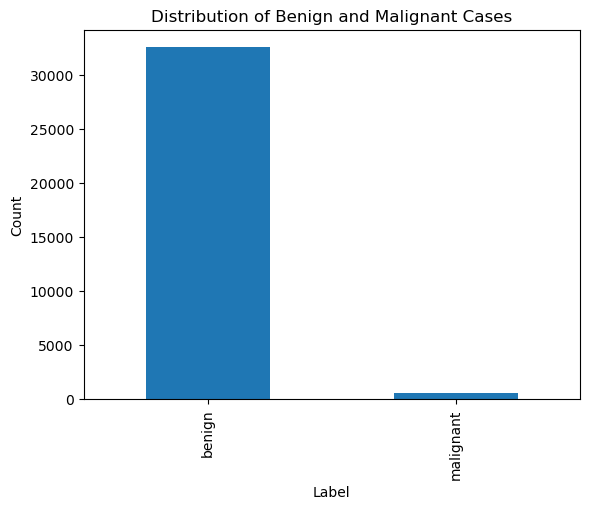

In [19]:
# Plot the distribution
labels_df['benign_malignant'].value_counts().plot(kind='bar')
plt.title('Distribution of Benign and Malignant Cases')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Preprocessing/Contour Take 5:
-Grayscale and resize
-CLAHE increased contrast
-DHR algorithm with BlackHat transformation
    -Binary thresholding to make black and white
    -3 iterations of dilation and erosion
    -Inpainting
    -Binary thresholding for inpainted images
    -Median filtering
    -Minimum contour size
-Shows first 5 images using these parameters

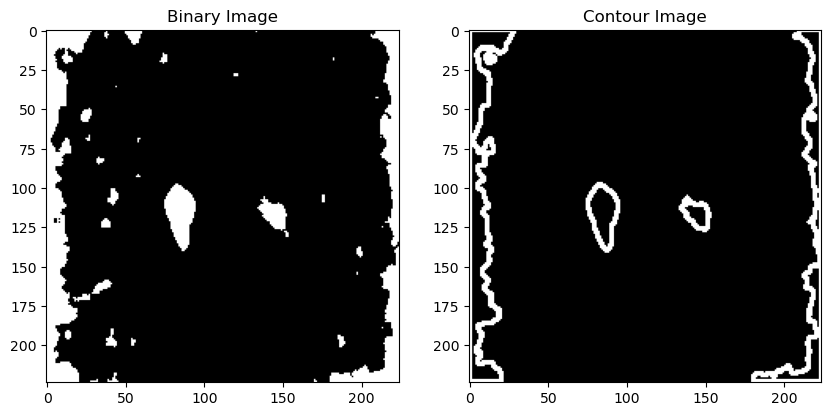

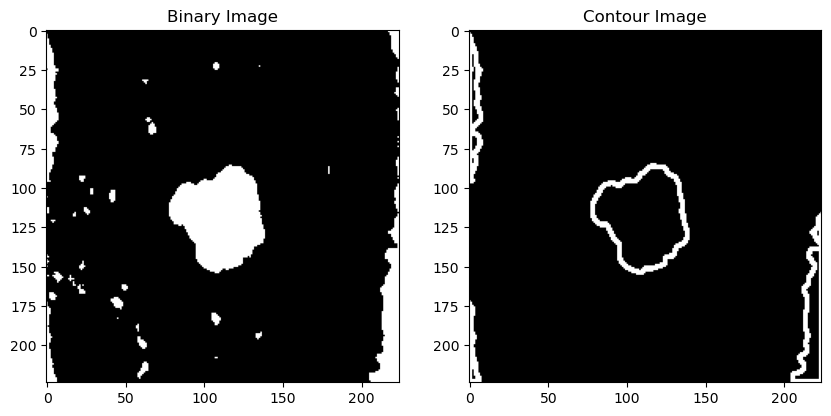

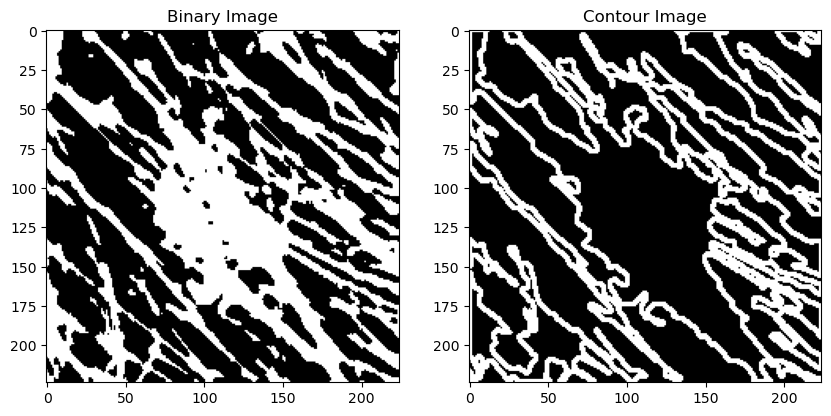

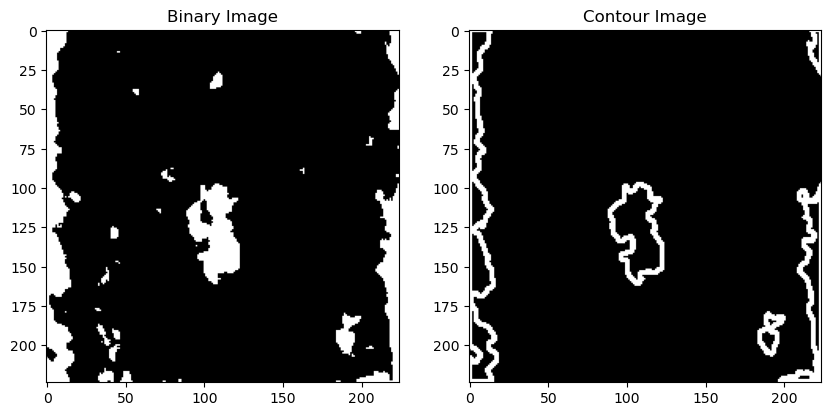

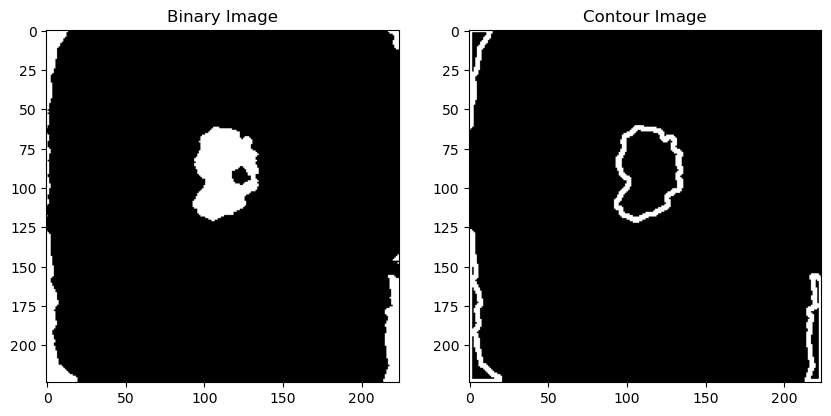

In [44]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

# Directory containing JPEG images
image_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Train_images\train"

# Target size for resizing
target_size = (224, 224) # Just using standard size for now

# Processed image directory
processed_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Processed_images"
os.makedirs(processed_dir, exist_ok=True)

def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE to increase contrast
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    contrast_image = clahe.apply(gray_image)
    
    # Remove hairs using enhanced DHR algorithm
    # Step 1: Morphological BlackHat transformation with a larger kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (31, 31))
    blackhat = cv2.morphologyEx(contrast_image, cv2.MORPH_BLACKHAT, kernel)
    
    # Step 2: Binary thresholding
    _, binary_thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    
    # Step 3: Multiple iterations of dilation and erosion to enhance hair regions
    dilated_thresh = cv2.dilate(binary_thresh, kernel, iterations=3)
    eroded_thresh = cv2.erode(dilated_thresh, kernel, iterations=3)
    
    # Step 4: Inpainting
    inpainted_image = cv2.inpaint(contrast_image, eroded_thresh, 1, cv2.INPAINT_TELEA)
    
    # Apply binary thresholding to make the lesion black and background white
    _, binary_image = cv2.threshold(inpainted_image, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Apply median filtering to remove salt-and-pepper noise
    median_filtered_image = cv2.medianBlur(binary_image, 5)
    
    return median_filtered_image

def find_contours(binary_image, min_contour_area=100):
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter contours by size
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) >= min_contour_area]
    return filtered_contours

def draw_contours_on_blank(contours, target_size):
    # Create a blank image
    contour_image = np.zeros((target_size[0], target_size[1]), dtype=np.uint8)
    # Draw contours on the blank image
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)
    return contour_image

# Check for .jpg files in the directory
jpg_files = glob(os.path.join(image_dir, '*.jpg'))
if not jpg_files:
    print("No .jpg files found in the specified directory.")
else:
    # Process and draw contours for the first 5 images to check quality
    for image_path in jpg_files[:5]:
        processed_image = preprocess_image(image_path)
        contours = find_contours(processed_image, min_contour_area=100) # Get rid of small blobs
        
        contour_image = draw_contours_on_blank(contours, target_size)
        
        # Display binary and contour images
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Binary Image")
        plt.imshow(processed_image, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title("Contour Image")
        plt.imshow(contour_image, cmap='gray')
        plt.show()
        
        # Save contour images
        image_name = os.path.basename(image_path)
        save_path = os.path.join(processed_dir, 'contours_' + image_name)
        cv2.imwrite(save_path, contour_image)


# Preprocessing for all images:

In [ ]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

# Directory containing JPEG images
image_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Train_images\train"

# Target size for resizing
target_size = (224, 224)

# Processed image directory
processed_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Processed_images"
os.makedirs(processed_dir, exist_ok=True)

def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE to increase contrast
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    contrast_image = clahe.apply(gray_image)
    
    # Remove hairs using enhanced DHR algorithm
    # Step 1: Morphological BlackHat transformation with a larger kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (31, 31))
    blackhat = cv2.morphologyEx(contrast_image, cv2.MORPH_BLACKHAT, kernel)
    
    # Step 2: Binary thresholding
    _, binary_thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    
    # Step 3: Multiple iterations of dilation and erosion to enhance hair regions
    dilated_thresh = cv2.dilate(binary_thresh, kernel, iterations=3)
    eroded_thresh = cv2.erode(dilated_thresh, kernel, iterations=3)
    
    # Step 4: Inpainting
    inpainted_image = cv2.inpaint(contrast_image, eroded_thresh, 1, cv2.INPAINT_TELEA)
    
    # Apply binary thresholding to make the lesion black and background white
    _, binary_image = cv2.threshold(inpainted_image, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Apply median filtering to remove salt-and-pepper noise
    median_filtered_image = cv2.medianBlur(binary_image, 5)
    
    return median_filtered_image

def find_contours(binary_image, min_contour_area=100):
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter contours by size
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) >= min_contour_area]
    return filtered_contours

def draw_contours_on_blank(contours, target_size):
    # Create a blank image
    contour_image = np.zeros((target_size[0], target_size[1]), dtype=np.uint8)
    # Draw contours on the blank image
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)
    return contour_image

# Check for .jpg files in the directory
jpg_files = glob(os.path.join(image_dir, '*.jpg'))
if not jpg_files:
    print("No .jpg files found in the specified directory.")
else:
    # Process and draw contours for all images
    for image_path in jpg_files:
        processed_image = preprocess_image(image_path)
        contours = find_contours(processed_image, min_contour_area=100)
        
        contour_image = draw_contours_on_blank(contours, target_size)
        
        # Save the contour images
        image_name = os.path.basename(image_path)
        save_path = os.path.join(processed_dir, 'contours_' + image_name)
        cv2.imwrite(save_path, contour_image)


# Crop already preprocessed data:
-Use to adjust crop margin

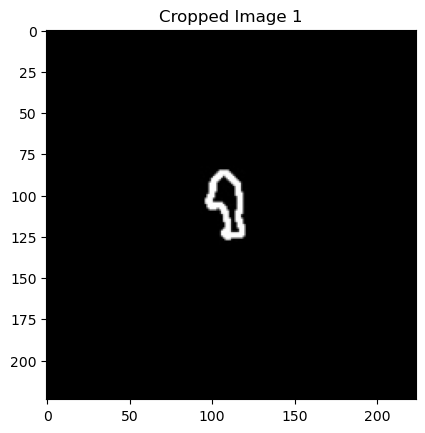

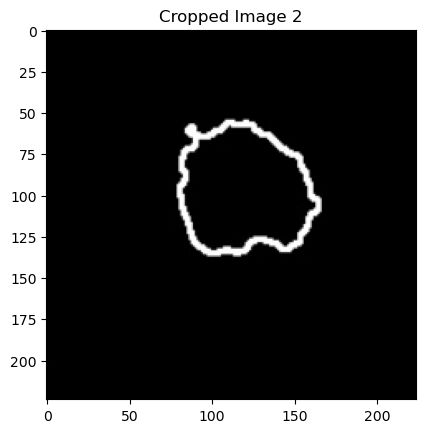

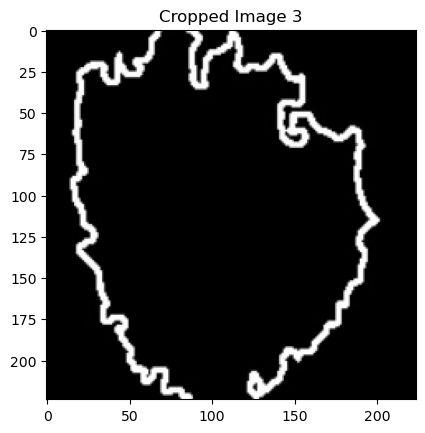

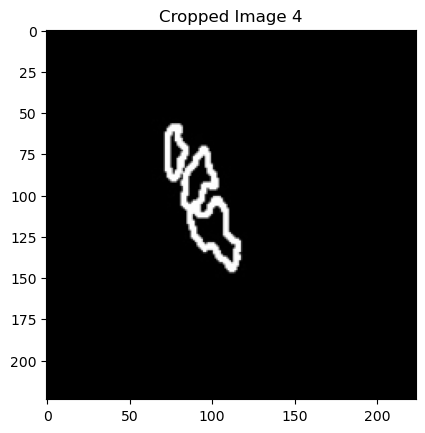

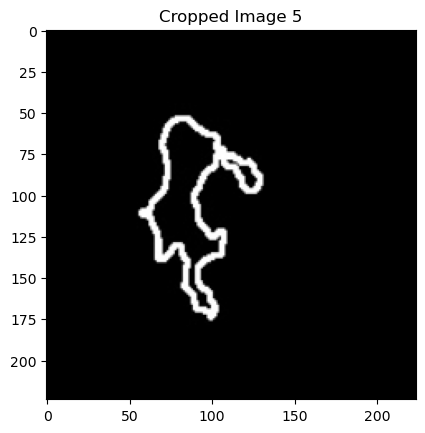

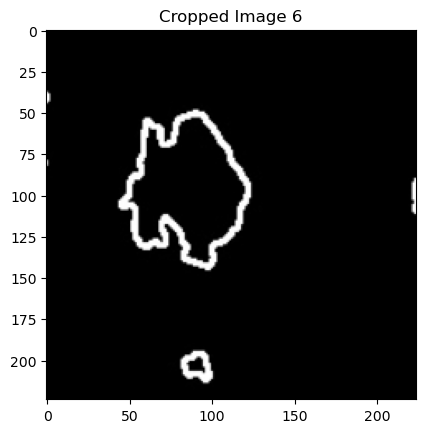

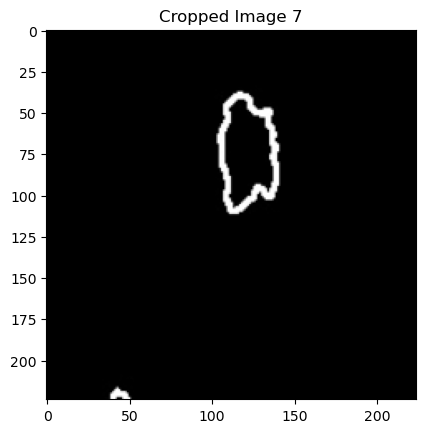

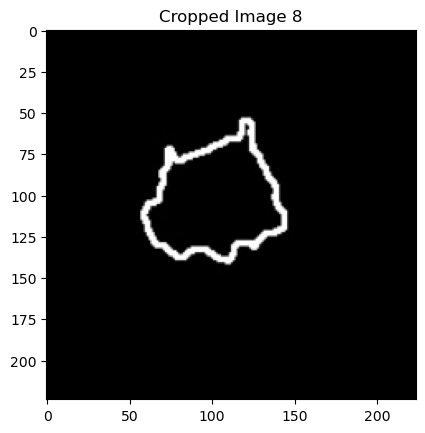

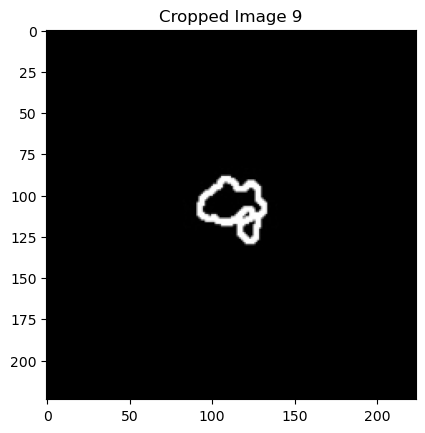

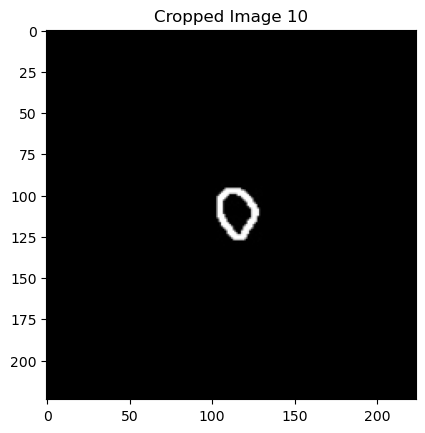

Cropped and saved the first 10 images to C:\Users\Zoiya\OneDrive\Courses\ISIC\Cropped_Contours


In [10]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

# Directory containing preprocessed/contoured images
contoured_image_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Filtered_Contour\Filtered Contour"

# Directory to save cropped images
cropped_image_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Cropped_Contours"
os.makedirs(cropped_image_dir, exist_ok=True)

# Target size for resizing
target_size = (224, 224)

def crop_image(image_path, crop_margin):
    # Read the image
    image = cv2.imread(image_path)
    
    # Crop the edges of the image
    cropped_image = image[crop_margin:-crop_margin, crop_margin:-crop_margin]
    
    # Resize the image back to the target size
    cropped_image = cv2.resize(cropped_image, target_size)
    
    return cropped_image

# Check for contour images in the directory
contour_files = glob(os.path.join(contoured_image_dir, 'contours_*.jpg'))
if not contour_files:
    print("No contour files found in the specified directory.")
else:
    # Crop the images and display the first 10
    crop_margin = 20  # Keep adjusting based on results below
    for i, image_path in enumerate(contour_files[:10]):
        cropped_image = crop_image(image_path, crop_margin)
        
        # Display the cropped image
        plt.figure()
        plt.title(f"Cropped Image {i+1}")
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.show()
        
        # Save the cropped image with the new naming
        image_name = os.path.basename(image_path).replace('contours_', '')
        save_path = os.path.join(cropped_image_dir, image_name)
        cv2.imwrite(save_path, cropped_image)
    
    print(f"Cropped and saved the first 10 images to {cropped_image_dir}")


# All contour images cropped:

In [16]:
import cv2
import numpy as np
import os
from glob import glob

# Directory containing preprocessed/contoured images
contoured_image_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Filtered_Contour\Filtered Contour"

# Directory to save cropped images
cropped_image_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Cropped_Contours"
os.makedirs(cropped_image_dir, exist_ok=True)

# Target size for resizing
target_size = (224, 224)

def crop_image(image_path, crop_margin):
    # Read the image
    image = cv2.imread(image_path)
    
    # Crop the edges of the image
    cropped_image = image[crop_margin:-crop_margin, crop_margin:-crop_margin]
    
    # Resize the image back to the target size
    cropped_image = cv2.resize(cropped_image, target_size)
    
    return cropped_image

# Check for contour images in the directory
contour_files = glob(os.path.join(contoured_image_dir, 'contours_*.jpg'))
if not contour_files:
    print("No contour files found in the specified directory.")
else:
    # Crop all the contour images
    crop_margin = 20  # Adjusted several times--this seems to work best
    for image_path in contour_files:
        cropped_image = crop_image(image_path, crop_margin)
        
        # Save the cropped image with the new naming
        image_name = os.path.basename(image_path).replace('contours_', '')
        save_path = os.path.join(cropped_image_dir, image_name)
        cv2.imwrite(save_path, cropped_image)
    
    print(f"Cropped and saved all contour images to {cropped_image_dir}")


Cropped and saved all contour images to C:\Users\Zoiya\OneDrive\Courses\ISIC\Cropped_Contours


# Sort via benign vs malignant:

In [17]:
import cv2
import numpy as np
import os
import pandas as pd
from glob import glob

# Directory containing cropped contour images
cropped_image_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Cropped_Contours"

# Directory to save sorted images
benign_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Sorted_Images\Benign"
malignant_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Sorted_Images\Malignant"
os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

# Path to the ground truth CSV file
ground_truth_csv = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\ISIC_2020_Training_GroundTruth.csv"

# Load the ground truth data
ground_truth_df = pd.read_csv(ground_truth_csv)

# Check for cropped images in the directory
cropped_files = glob(os.path.join(cropped_image_dir, '*.jpg'))
if not cropped_files:
    print("No cropped images found in the specified directory.")
else:
    for image_path in cropped_files:
        image_name = os.path.basename(image_path)
        
        # Remove file extension
        image_id = os.path.splitext(image_name)[0]
        
        # Check if the image_id is in the ground truth data
        if image_id in ground_truth_df['image_name'].values:
            # Get the target value for the image
            target_value = ground_truth_df.loc[ground_truth_df['image_name'] == image_id, 'target'].values[0]
            
            # Determine benign or malignant
            if target_value == 0:
                dest_dir = benign_dir
            else:
                dest_dir = malignant_dir
            
            # Copy the image to folder
            save_path = os.path.join(dest_dir, image_name)
            cv2.imwrite(save_path, cv2.imread(image_path))
    
    print(f"Sorted images into {benign_dir} and {malignant_dir}")



Sorted images into C:\Users\Zoiya\OneDrive\Courses\ISIC\Sorted_Images\Benign and C:\Users\Zoiya\OneDrive\Courses\ISIC\Sorted_Images\Malignant


# Create balanced dataset:

In [18]:
import os
import shutil
import random

# Directory to create the balanced dataset
balanced_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Balanced"
os.makedirs(balanced_dir, exist_ok=True)

# Function to select and copy 519 images
def select_and_copy_images(src_dir, dest_dir, num_images):
    images = glob(os.path.join(src_dir, '*.jpg'))
    selected_images = random.sample(images, num_images)
    for image_path in selected_images:
        shutil.copy(image_path, dest_dir)

# Copy 519 images from Benign and Malignant folders to the Balanced folder
select_and_copy_images(benign_dir, balanced_dir, 519)
select_and_copy_images(malignant_dir, balanced_dir, 519)

# Create directories for train and test splits
train_dir = os.path.join(balanced_dir, 'train')
test_dir = os.path.join(balanced_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split images into train and test sets (80/20 split)
balanced_images = glob(os.path.join(balanced_dir, '*.jpg'))
random.shuffle(balanced_images)
split_index = int(0.8 * len(balanced_images))

train_images = balanced_images[:split_index]
test_images = balanced_images[split_index:]

# Copy images to train and test folders
for image_path in train_images:
    shutil.copy(image_path, train_dir)

for image_path in test_images:
    shutil.copy(image_path, test_dir)

print(f"Balanced dataset created with {len(train_images)} training images and {len(test_images)} testing images.")


Balanced dataset created with 830 training images and 208 testing images.


# Best CNN:
-Medium CNN
-Early stopping
-Batch size of 32
-50 Epochs
-Slight data augmentation

In [33]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Seed
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Directory containing images
train_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Balanced\train"
test_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Balanced\test"

# Load the ground truth data
ground_truth_csv = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\ISIC_2020_Training_GroundTruth.csv"
ground_truth_df = pd.read_csv(ground_truth_csv)

# Data preprocessing
def load_images_and_labels(directory, ground_truth_df):
    images = []
    labels = []
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        image_id = os.path.splitext(image_name)[0]
        target = ground_truth_df.loc[ground_truth_df['image_name'] == image_id, 'target'].values[0]
        images.append(image)
        labels.append(target)
    return np.array(images), np.array(labels)

# Load training and test data
X_train_full, y_train_full = load_images_and_labels(train_dir, ground_truth_df)
X_test, y_test = load_images_and_labels(test_dir, ground_truth_df)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=seed)

# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Match dimensions of CNN
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Slight data augmentation
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode="nearest")

# CNN model with lots of layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))

# AUC score
auc = roc_auc_score(y_test, model.predict(X_test))
print(f"AUC: {auc:.2f}")


C:\Users\Zoiya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Zoiya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 507ms/step - accuracy: 0.5482 - loss: 0.7894 - val_accuracy: 0.6807 - val_loss: 0.6397
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accuracy: 0.6393 - loss: 0.6393 - val_accuracy: 0.6928 - val_loss: 0.6120
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 495ms/step - accuracy: 0.6911 - loss: 0.5805 - val_accuracy: 0.6988 - val_loss: 0.6020
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 468ms/step - accuracy: 0.6761 - loss: 0.6132 - val_accuracy: 0.6928 - val_loss: 0.6077
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - accuracy: 0.7025 - loss: 0.5817 - val_accuracy: 0.6747 - val_loss: 0.6066
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.7001 - loss: 0.6296 - val_accuracy: 0.6807 - val_loss: 0.6000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 486ms/step - accuracy: 0.7211 - loss: 0.5461 - val_accuracy: 0.6747 - val_loss: 0.6184
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 579ms/step - accuracy: 0.7024 - loss: 0.5762 - val_accu

# With rate learning, data augmentation, large CNN, and learning rate modification. 
-Doesn't work very well because data is already VERY preprocessed

In [25]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Seed
seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Directory containing images
train_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Balanced\train"
test_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Balanced\test"

# Load the ground truth data
ground_truth_csv = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\ISIC_2020_Training_GroundTruth.csv"
ground_truth_df = pd.read_csv(ground_truth_csv)

# Data preprocessing
def load_images_and_labels(directory, ground_truth_df):
    images = []
    labels = []
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        image_id = os.path.splitext(image_name)[0]
        target = ground_truth_df.loc[ground_truth_df['image_name'] == image_id, 'target'].values[0]
        images.append(image)
        labels.append(target)
    return np.array(images), np.array(labels)

# Load training and test data
X_train_full, y_train_full = load_images_and_labels(train_dir, ground_truth_df)
X_test, y_test = load_images_and_labels(test_dir, ground_truth_df)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=seed)

# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Match the input shape of the CNN
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.15,
    fill_mode="nearest"
)

# CNN with L2 regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001, verbose=1)

# Train
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))

# AUC score
auc = roc_auc_score(y_test, model.predict(X_test))
print(f"AUC: {auc:.2f}")


C:\Users\Zoiya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Zoiya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 765ms/step - accuracy: 0.5519 - loss: 13.7399 - val_accuracy: 0.5181 - val_loss: 2.4714 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 741ms/step - accuracy: 0.5502 - loss: 10.7207 - val_accuracy: 0.5000 - val_loss: 6.3070 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5686 - loss: 8.0718 - val_accuracy: 0.5181 - val_loss: 8.6736 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.5843 - loss: 4.6188
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5856 - loss: 4.5724 - val_accuracy: 0.5060 - val_loss: 12.3979 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 659ms/step - accuracy: 0.6326 - loss: 2.5075 - val_accuracy: 0.5602 - val_loss: 8.1542 - learning_rate: 1.0000e-04
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 762ms/step - accuracy: 0.6206 - loss: 2.

# Simpler CNN, removing a lot of fancy stuff

In [2]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Seed
seed = 4321
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Directory containing images
train_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Balanced\train"
test_dir = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\Balanced\test"

# Load the ground truth data
ground_truth_csv = r"C:\Users\Zoiya\OneDrive\Courses\ISIC\ISIC_2020_Training_GroundTruth.csv"
ground_truth_df = pd.read_csv(ground_truth_csv)

# Data preprocessing
def load_images_and_labels(directory, ground_truth_df):
    images = []
    labels = []
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        image_id = os.path.splitext(image_name)[0]
        target = ground_truth_df.loc[ground_truth_df['image_name'] == image_id, 'target'].values[0]
        images.append(image)
        labels.append(target)
    return np.array(images), np.array(labels)

# Load training and test data
X_train_full, y_train_full = load_images_and_labels(train_dir, ground_truth_df)
X_test, y_test = load_images_and_labels(test_dir, ground_truth_df)

# Split training into train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=seed)

# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Match the input shape of the CNN
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Simpler CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001, verbose=1)

# Train
history = model.fit(
    X_train, y_train, batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))

# AUC score
auc = roc_auc_score(y_test, model.predict(X_test))
print(f"AUC: {auc:.2f}")


C:\Users\Zoiya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 684ms/step - accuracy: 0.6029 - loss: 0.8385 - val_accuracy: 0.6446 - val_loss: 0.6544 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 653ms/step - accuracy: 0.7478 - loss: 0.5545 - val_accuracy: 0.6627 - val_loss: 0.6477 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 652ms/step - accuracy: 0.8837 - loss: 0.3316 - val_accuracy: 0.6325 - val_loss: 0.8392 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 633ms/step - accuracy: 0.9346 - loss: 0.1671 - val_accuracy: 0.6867 - val_loss: 1.1472 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9833 - loss: 0.0754
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 635ms/step - accuracy: 0.9830 - loss: 0.0760 - val_accuracy: 0.6506 - val_loss: 1.7984 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 642ms/step - accuracy: 0.9782 - loss: 0.0